In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

It seems like there are two main approaches to processing multisample data. One is to merge (or concatenate) the datasests into one single ``annadata`` and proceed with processing. We should follow this approach if are certain there are no batch effects betweem samples (e.g. if all sequences come from the same sequencing run). The other strategy is to perfrom data integration. This approach aims to asses possible confounding effects due to samples being processed in different batches before moving to subsequent downstram analysis. It looks like the later might be the safest strategy. At the same time, there are different ways to approach these strategies.

Since we do not know how our data was sequenced, we are going to assume no different batches between our samples. We are going to concatenate them. Here we have another problem: whether is more covenient to transform before or after merging. I two main problems in transforming before merging:

1. Filtering of genes is compromised, as we need to filter genes prior to transforming. This means that there will differences in the number of genes indexes, and the only solution to this is to 'inner' merge datasets, which will result in the loss of some genes.
2. Difference in sequencing depth between samples. There seems to be a solution in Seurat using ``PrepSCTFindMarkers()`` to correct transformed counts taking differences in sequencing depth between samples

According to the Seurat people, the recommended approach is generally to [transform before merging](https://github.com/satijalab/seurat/issues/7407). Although [here](https://github.com/satijalab/seurat/issues/6116) they say that if technical variation is not high, either approach should work.


### Normalization

Normalization and further UMI counts processing is important to adress the confounding effects of technical variation, since we are only interested in true biological variation. For instance, the difference in expression levels of a particular gene between cells can be associated to technical factors such as sequencing depth. The primary goal of single-cell normalization is to remove the influence of technical effects in the underlying molecular counts, while preserving true biological variation [view](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1). Additionally, Single-cell count matrix usually show heteroskedasticity, with high counts showing higher levels of variance [check](https://www.nature.com/articles/s41592-023-01814-1). Therefore, we could sat want our transformed data to follow these properties:

1. In general, the normalized expression level of a gene should not be correlated with the total sequencing depth of a cell. Downstream analytical tasks (dimensional reduction, differential expression) should also not be influenced by variation in sequencing depth.
2. The variance of a normalized gene (across cells) should primarily reflect biological heterogeneity, independent of gene abundance or sequencing depth. For example, genes with high variance after normalization should be differentially expressed across cell types, while housekeeping genes should exhibit low variance. Additionally, the variance of a gene should be similar when considering either deeply sequenced cells, or shallowly sequenced cells.

Referring to [Ahlmann-Eltze & Huber, 2023](https://www.nature.com/articles/s41592-023-01814-1), we will decribe two approaches which seem to perform best in rutinary analysis the delta method and model residuals, which will take care of both **variance stabilization and cell size** (is cell size library size?). **The delta method** uses the shifted algorith for variance stabilization and size factor normalization to account for differences sequencing depth. **The Pearson residulas method** utilizes Pearson residuals from ‘regularized negative binomial regression’ to calculate a model of technical noise in the data. It explicitly adds the count depth as a covariate in a generalized linear model to account for differences in library size ([from the Single-Cell Best Practices book](https://www.sc-best-practices.org/preprocessing_visualization/normalization.html)).

### 1. Post Meging Approach

First we read and load our preprocessed data and merge them into a single ``anndata``. We are going to use ``concat`` and ``join=outer`` so that the union of the axes is taken. Barcodes should concatenate and share the same ``var_indexes`` (or genes):

In [2]:
raw_files = sorted([os.path.abspath("..") + f"/{i}" for i in os.listdir("..") if ".h5ad" in i])
raw_files
#adatas = [sc.read(adata) for adata in raw_files[0]]
adata = sc.read(raw_files[0])

In [3]:
# adata = sc.concat(adatas, join="outer")

Looks like barcode names are not unique across samples. Let's make them unique:

In [4]:
adata.obs_names_make_unique()

Now we remove those genes with very low read counts since they are not very informative and will make computation more efficient. We will finlter genes that are not present in at least 20 cells:

In [5]:
sc.pp.filter_genes(adata, min_cells=20)

More than half of the genes were removed. Remember that, in addition to concatenation, we also changed our default sparse matrix from **raw counts** to the **modfied counts from ``Soupx``**. Therefore, it would be a good idea to to recalculate our quality metrics:

In [6]:
qc_metrics = sc.pp.calculate_qc_metrics(adata)
adata.obs[qc_metrics[0].columns] = qc_metrics[0]
adata.var[qc_metrics[1].columns] = qc_metrics[1]

We can plot a gene agains the total counts of each gene to see the effect sequencing depth has on the counts. We are going list housekeeping genes which should not show differences in expression between cells:

In [7]:
markers = ["GAPDH", "PGK1", "RPL13A"]

And create a function to plot our data:

In [8]:
def plot_markers(adata, markers):
    
    #for adata in adatas:
        # We are going to create a dataframe by selecting the log1p total counts for each cell as well as the counts for each marker gene
    plotdf = sc.get.obs_df(adata, keys=["log1p_total_counts", *markers])
        
        #sample = adata.obs["sample"].iloc[0]

        #n_rows = math.ceil(len(markers)/3) 
        
    fig, axs = plt.subplots(1, 3, figsize=(12,3))

    #fig.suptitle(sample)

    fig.tight_layout()

    if len(np.shape(axs)):
        axs = axs.flat
        
    for marker,ax in zip(markers,axs):
        plotdf[marker] = np.log1p(plotdf[marker]) # We want the log values
        ax.scatter(x="log1p_total_counts", y=marker, data=plotdf, s=1)
        ax.set_title(marker)
        ax.set_xlabel("total counts")
        ax.set_ylabel("gene counts")

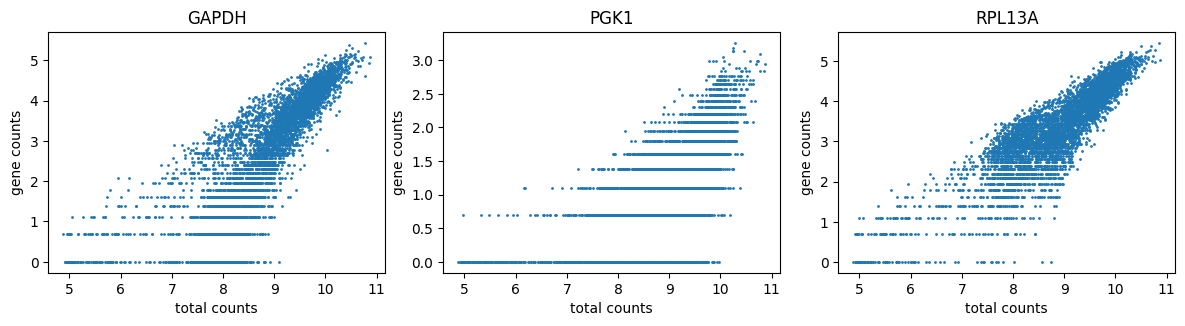

In [9]:
plot_markers(adata, markers)

We can also check the mean-variance relatioship by plotting both varialbes. Generally, if we want to observe biological differences, variability across means should be stable, and not follow any trends. This is not usually the case for count data. We will use the standard deviation to plot this relationship **Not sure**. Before, we are going to write a function to calculate the variance and mean of genes from the sparse matrix:

In [10]:
def sparse_mean_var(sparse_matrix):
    square_matrix = sparse_matrix.power(2)
    mean = np.array(sparse_matrix.mean(axis=1)).flatten()
    squares_mean = np.array(square_matrix.mean(axis=1)).flatten()
    squared_mean = np.square(mean)
    var = squares_mean - squared_mean
    return mean,var

We are going to use the mean expression of the ``log1p`` counts for each gene vs their variance, and define a new function for plotting:

In [11]:
def plot_mean_var(adata, layer=None):
    # Let's first tranform the data into log1p values
    if layer != None:
        sparse_matrix = adata.layers[layer]
    else:
        sparse_matrix = adata.X
    # And now we can calculate the row means and variance. Remember that rows are barcodes, therefore we need to transpose to get genes as rows
    mean, var = sparse_mean_var(sparse_matrix.T)
    df = pd.DataFrame({"mean":np.log1p(mean), "var":np.log1p(var)})
    plt.scatter(x="mean", y="var", data=df.sort_values("mean", ascending=False))
    plt.xlabel("log1p mean")
    plt.ylabel("log1p var")

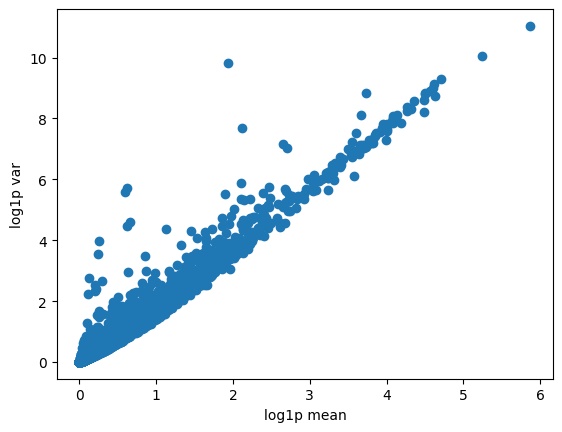

In [12]:
plot_mean_var(adata)

We can see that the relationship between the mean and the variance is quadratic, as is expected with UMI counts, as a theoretically and empirically established model for UMI data is the Gamma-Poisson distribution, which implies a quadratic mean-variance relation. Let's now tranform our data using the **Pearson residuals method**

In [13]:
from scipy.sparse import csr_matrix
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
# The previous step gave us a dictionary, we nee to convert it to a matrix
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

In [14]:
del analytic_pearson

We are also going to use the shifted algorithm method for normalization, and save it as a new value:

In [15]:
#scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
#adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

Let's plot the mean-variance relationship again:

In [ ]:
plot_mean_var(adata, "analytic_pearson_residuals")

Looks like maeans are centered around 0. And we can see that the dispersion of means increases with the variance, which is something I guess we would expect from expression data, since those are probably highly variable genes.

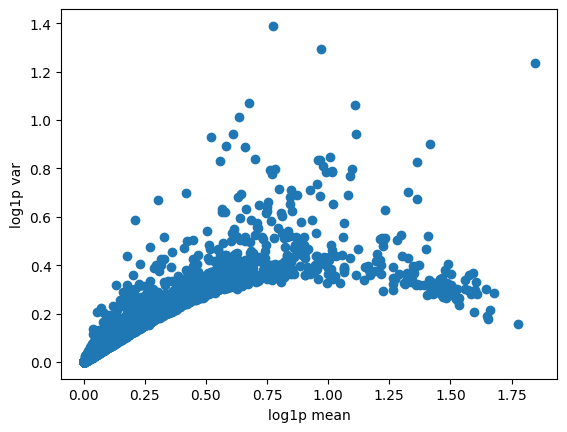

In [57]:
plot_mean_var(adata, "log1p_norm")

I do not know what to say about this.

### Featuring selection

The next step is to select the most informative genes, this is called **feature selection**.Feature selection methods should ideally select genes that explain the biological variation in a data set by prioritizing those that vary between subpopulations rather than within one subpopulation, without affecting the identifiability of small subpopulations (from [paper](file:///C:/Users/dfern/Downloads/s41576-023-00586-w.pdf)). And why the most informative genes? Discarding uniformative genes will reduce the number of dimensions and increase the performance of downstream analysis methods like clustering and dimensionality reduction , as the noise from this genes migtth hide the signal of relevant features. Therefore, we need to subset to the most informative genes thta better explain the heterogeneity between cell subpopulations.

One of the most common approaches is to select highly variable genes. But apparently there is a problem with this method, since it is very sensitive to normalization. For instance, in the case of the delta method, the addition of a pseudocount to deal with genes with 0 counts when log transforming increases the variability of genes with zero counts. **I do not know why this is not recommended with Pearson residuals, better find out**

The use of deviance seems to be a feasable alternative for future selection ([see](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02136-7)). It quantifies how well each gene fits a null model of constant expression across cells (from [paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)). Deviance selects genes that are both highly expressed and highly variable and it works on the raw counts, therefore overcoming the disadvantages of normalization.

**Something I find interesting is that for transformation UMI counts are modelled according to a negative binomial model with sequencing depth as covariate, whereas for feature selection using deviance a multinomial model is assumed.**

We are going to use the ``scry`` **Bioconductor** package, which ranks genes according to deviance.